In [0]:
%pip install pytorch

In [0]:
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df = pd.read_csv("Train_TEC_mar17.csv")
# df.columns
df.drop(["Date", "Month", "Year", "Time"], axis=1, inplace=True)
df

,LT,TEC
0,5.311333,2.067562
1,5.344670,2.082707
2,5.378006,2.004272
3,5.411343,1.736569
4,5.444679,1.758503
...,...,...
14395,29.144887,1.717251
14396,29.178223,1.653964
14397,29.211560,1.315151
14398,29.244896,1.293472


In [0]:
df.shape

(14400, 2)

In [0]:
df.columns

Index(['LT', 'TEC'], dtype='object')

In [0]:
all_data = df.TEC.values.astype("float")

In [0]:
all_data

array([2.06756223, 2.08270718, 2.00427205, ..., 1.3151513 , 1.29347241,
       1.63374075])

In [0]:
df

,LT,TEC
0,5.311333,2.067562
1,5.344670,2.082707
2,5.378006,2.004272
3,5.411343,1.736569
4,5.444679,1.758503
...,...,...
14395,29.144887,1.717251
14396,29.178223,1.653964
14397,29.211560,1.315151
14398,29.244896,1.293472


In [0]:
train_data = all_data[:-1440]
test_data = all_data[-1440:]
print(len(train_data), len(test_data))

12960 1440


In [0]:
print(test_data)

[2.19222146 2.20890666 2.57218469 ... 1.3151513  1.29347241 1.63374075]


In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [0]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.91466338]
 [-0.91393794]
 [-0.91769497]
 [-0.93051789]
 [-0.92946726]]
[[-0.95111961]
 [-0.94624329]
 [-0.95929515]
 [-0.96726307]
 [-0.95595248]]


In [0]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
len(train_data_normalized)

12960

In [0]:
train_window = 720

In [0]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
len(train_inout_seq)

12240

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [0]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [0]:
epochs = 5
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [0]:
fut_pred = 20 

test_inputs = train_data_normalized[-train_window * 720: ].tolist()
print(test_inputs)

[-0.9146633744239807, -0.9139379262924194, -0.9176949858665466, -0.9305179119110107, -0.9294672608375549, -0.9394888877868652, -0.9302916526794434, -0.948512077331543, -0.9631493091583252, -0.9588348269462585, -0.9640654921531677, -0.9515865445137024, -0.9506737589836121, -0.9529029130935669, -0.9675918221473694, -0.9841243028640747, -0.9663519859313965, -0.9608611464500427, -0.9652278423309326, -0.9642382264137268, -0.957487940788269, -0.941652238368988, -0.9531528353691101, -0.9673479199409485, -0.9625042080879211, -0.9607006907463074, -0.9583267569541931, -0.9568100571632385, -0.9315447211265564, -0.9186248779296875, -0.9132637977600098, -0.892498254776001, -0.8960416913032532, -0.894031822681427, -0.8830562233924866, -0.8719258904457092, -0.8325260281562805, -0.8195067644119263, -0.784737765789032, -0.7782924771308899, -0.7620010375976562, -0.7515007257461548, -0.7412094473838806, -0.7311041951179504, -0.7376672625541687, -0.7147971987724304, -0.6896587014198303, -0.680590569972991

In [0]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

test_inputs[fut_pred:]

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)



[[1.17351788]
 [1.50411839]
 [1.26402148]
 ...
 [1.37730808]
 [1.37730808]
 [1.37730808]]


In [0]:
len(test_inputs[fut_pred:])

12980

In [0]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(len(actual_predictions))


12980


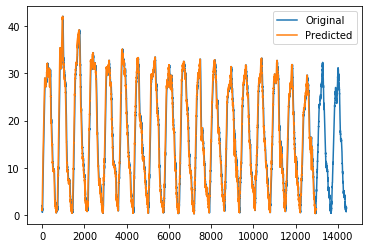

In [0]:
plt.plot(df["TEC"], Label = "Original")
plt.plot(actual_predictions, Label = "Predicted")
plt.legend()

In [0]:
from statsmodels.tools.eval_measures import rmse
rmse(test(df["TEC"][-1440:]), test_inputs[fut_pred:])

NameError: ignored